In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import h2o
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from h2o.estimators import H2ORandomForestEstimator

# Set up reporting to check how well the model does
def report(actual, predicted):
    AUC = roc_auc_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    print('AUC: ', AUC)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('Confusion Matrix:')
    conf_matrix = confusion_matrix(actual, predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

In [2]:
# Initialize h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 days 19 hours 21 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_Her_Computer_ps47rr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,304.0 Mb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [3]:
# Load data into h2o frames
h2o_train_data = h2o.import_file('train_data.csv')
h2o_test_data = h2o.import_file('test_data.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
# Get list of all columns
pandas_test_data = h2o.as_list(h2o_test_data)
result=pandas_test_data.pop('readmitted')
features_list = pandas_test_data.columns.values.tolist()

# Set predictor and response columns
h2o_training_columns = features_list
h2o_response_column = 'readmitted'

# Train Random Forest with h2o
drf = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
drf.train(x=h2o_training_columns, y=h2o_response_column, training_frame=h2o_train_data)

# Make predictions
train_prediction = drf.predict(h2o_train_data[h2o_training_columns])
test_prediction = drf.predict(h2o_test_data[h2o_training_columns])

C:\ProgramData\Anaconda3\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [metformin-pioglitazone]
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


AUC:  0.507390866637673
Accuracy:  0.8901896425966448
Precision:  0.4
Recall:  0.018096514745308313
Confusion Matrix:


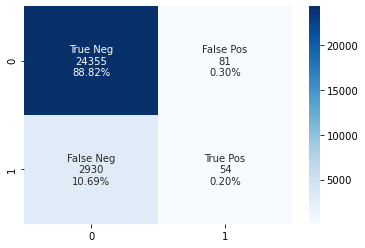

In [5]:
# Round predictions and convert to ingegers
train_predict_list = h2o.as_list(train_prediction)
train_predict_list = train_predict_list.round(0)
train_predict_list = train_predict_list.astype(int)

test_predict_list = h2o.as_list(test_prediction)
test_predict_list = test_predict_list.round(0)
test_predict_list = test_predict_list.astype(int)

# Display report
report(result, test_predict_list)